# Hands-On Exercises: ETF Flash Crash Analysis - **SOLUTIONS**

**Track**: Core | **Difficulty**: ⭐⭐ Intermediate | **Time**: 60-90 minutes

**Prerequisites**:
- Completed notebooks 01 and 02
- Understanding of NAV, iNAV, LULD, and order types

**Learning Objectives**:
1. Calculate NAV and iNAV for ETFs
2. Simulate order book dynamics during flash crash
3. Analyze stop-loss order cascades
4. Compare different order types and their outcomes
5. Understand arbitrage opportunities and constraints

---

**NOTE: This is the SOLUTIONS notebook with all exercises completed.**

For the student version with TODO markers, see: `notebooks/core/03-hands-on-exercises.ipynb`

---

## Setup

In [1]:
# ============================================================================
# SETUP - Hands-On Exercises - SOLUTIONS
# ============================================================================

import sys
import os
from pathlib import Path

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running in local Jupyter environment")

# Setup for Colab
if IN_COLAB:
    print("\n📥 Setting up Colab environment...")
    
    if not os.path.exists('/content/etf-flash-crash-2015'):
        print("  Cloning repository...")
        !git clone https://github.com/shiong-tan/etf-flash-crash-2015.git /content/etf-flash-crash-2015
        print("  ✅ Repository cloned")
    else:
        print("  ✅ Repository exists")
    
    print("  Installing dependencies...")
    !pip install -q pandas numpy matplotlib seaborn
    print("  ✅ Dependencies installed")
    
    os.chdir('/content/etf-flash-crash-2015')
    sys.path.insert(0, '/content/etf-flash-crash-2015/src')
    
else:
    print("\n📂 Setting up local environment...")
    notebook_dir = Path().resolve()
    
    # Determine src directory location based on notebook location
    # This notebook is in: notebooks/solutions/core/
    # Need to go up 3 levels to reach project root
    
    # Case 1: In notebooks/solutions/core/ → go up 3 levels
    if notebook_dir.parent.name == 'solutions' and notebook_dir.parent.parent.name == 'notebooks':
        project_root = notebook_dir.parent.parent.parent
        src_dir = project_root / 'src'
    # Case 2: In notebooks/core/ or notebooks/extensions/ → go up 2 levels
    elif notebook_dir.parent.name == 'notebooks':
        project_root = notebook_dir.parent.parent
        src_dir = project_root / 'src'
    # Case 3: In notebooks/ directory → go up 1 level
    elif notebook_dir.name == 'notebooks':
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
    # Case 4: In project root (has notebooks/ subdirectory) → use directly
    elif (notebook_dir / 'notebooks').exists():
        project_root = notebook_dir
        src_dir = project_root / 'src'
    # Case 5: Fallback - assume we're one level deep
    else:
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
    
    sys.path.insert(0, str(src_dir))
    print(f"  ✅ Added src to path: {src_dir}")

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import our modules
from etf_pricing import calculate_nav, calculate_inav, arbitrage_spread
from order_book import OrderBook
from order_book_dynamics import FlashCrashOrderBook

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

if IN_COLAB:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
else:
    try:
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass

print("\n" + "="*60)
print("✅ SETUP COMPLETE - Solutions notebook ready!")
print("="*60)

💻 Running in local Jupyter environment

📂 Setting up local environment...
  ✅ Added src to path: /Users/shiongtan/projects/etf-flash-crash-2015/src



✅ SETUP COMPLETE - Solutions notebook ready!


---

## Exercise 1: NAV and iNAV Calculation

**Scenario**: You manage a small ETF that tracks 5 technology stocks. Calculate the NAV and iNAV under different market conditions.

### Part A: Normal Market Conditions

In [2]:
# ETF Holdings - separate shares from prices
holdings_shares = {
    'AAPL': 100,
    'MSFT': 80,
    'GOOGL': 50,
    'NVDA': 60,
    'META': 70
}

# Yesterday's closing prices
closing_prices = {
    'AAPL': 150.00,
    'MSFT': 300.00,
    'GOOGL': 140.00,
    'NVDA': 450.00,
    'META': 320.00
}

# Current intraday prices (10:00 AM)
current_prices = {
    'AAPL': 151.50,
    'MSFT': 302.00,
    'GOOGL': 141.20,
    'NVDA': 455.00,
    'META': 318.50
}

# ETF parameters
shares_outstanding = 10000
cash = 5000.00
liabilities = 1000.00
creation_unit_size = 50000  # For iNAV calculation
cash_per_unit = 250.00      # Cash component per creation unit

# SOLUTION: Calculate NAV using yesterday's close prices
nav = calculate_nav(holdings_shares, closing_prices, shares_outstanding, cash, liabilities)

# SOLUTION: Calculate iNAV using current prices
inav = calculate_inav(holdings_shares, current_prices, creation_unit_size, cash_per_unit)

print(f"NAV (end of yesterday): ${nav:.2f}")
print(f"iNAV (current 10:00 AM): ${inav:.2f}")

print(f"\n📊 Analysis:")
print(f"   ETF value increased ${inav - nav:.2f} per share (+{((inav/nav - 1)*100):.2f}%)")
print(f"   This reflects the overnight price movements in holdings")

NAV (end of yesterday): $9.94
iNAV (current 10:00 AM): $1.92

📊 Analysis:
   ETF value increased $-8.02 per share (+-80.64%)
   This reflects the overnight price movements in holdings


### Part B: Flash Crash Scenario

Now simulate August 24, 2015 conditions: some stocks are halted and use stale prices.

In [3]:
# Flash crash scenario: GOOGL, NVDA, META are halted (use stale prices)
flash_crash_prices = {
    'AAPL': 145.00,  # Trading (down 3.3%)
    'MSFT': 285.00,  # Trading (down 5.0%)
    'GOOGL': 140.00,  # HALTED - using stale price from close
    'NVDA': 450.00,   # HALTED - using stale price from close
    'META': 320.00    # HALTED - using stale price from close
}

# SOLUTION: Calculate iNAV with mixed stale/current prices
flash_inav = calculate_inav(holdings_shares, flash_crash_prices, creation_unit_size, cash_per_unit)

# SOLUTION: Calculate what iNAV SHOULD be if all stocks fell 5%
true_prices = {
    'AAPL': 145.00,
    'MSFT': 285.00,
    'GOOGL': 133.00,  # Down 5%
    'NVDA': 427.50,   # Down 5%
    'META': 304.00    # Down 5%
}

true_inav = calculate_inav(holdings_shares, true_prices, creation_unit_size, cash_per_unit)

print(f"Reported iNAV (with stale prices): ${flash_inav:.2f}")
print(f"True fair value (if all trading): ${true_inav:.2f}")

error = ((flash_inav - true_inav) / true_inav) * 100
print(f"\niNAV Calculation Error: {error:.2f}%")
print(f"\n⚠️  Market makers see ${flash_inav:.2f} but true value is ${true_inav:.2f}!")
print("This is why arbitrage breaks down during flash crashes.")
print(f"\n📊 Analysis:")
print(f"   Stale prices overstate iNAV by ${flash_inav - true_inav:.2f}")
print(f"   60% of holdings (GOOGL, NVDA, META) are halted")
print(f"   Market makers can't trust iNAV for arbitrage pricing")

Reported iNAV (with stale prices): $1.88
True fair value (if all trading): $1.82

iNAV Calculation Error: 3.09%

⚠️  Market makers see $1.88 but true value is $1.82!
This is why arbitrage breaks down during flash crashes.

📊 Analysis:
   Stale prices overstate iNAV by $0.06
   60% of holdings (GOOGL, NVDA, META) are halted
   Market makers can't trust iNAV for arbitrage pricing


**Question**: Why is the iNAV calculation misleading during the flash crash?

*Write your answer here*:

---

## Exercise 2: Order Book Simulation

Simulate an order book during normal conditions, then watch it deteriorate during a flash crash.

### Part A: Build a Normal Order Book

In [4]:
# Create order book for SPY at $200
book = OrderBook()

# SOLUTION: Add limit buy orders (bids)
book.add_bid(199.99, 500)
book.add_bid(199.98, 750)
book.add_bid(199.95, 1000)
book.add_bid(199.92, 800)
book.add_bid(199.90, 600)
book.add_bid(199.85, 400)
book.add_bid(199.80, 300)

# SOLUTION: Add limit sell orders (asks)
book.add_ask(200.01, 500)
book.add_ask(200.02, 750)
book.add_ask(200.05, 1000)
book.add_ask(200.08, 800)
book.add_ask(200.10, 600)
book.add_ask(200.15, 400)
book.add_ask(200.20, 300)

# Display the order book
print("\n=== NORMAL ORDER BOOK ===")
print(book.display_book(levels=5))

# Calculate bid-ask spread
best_bid = book.get_best_bid()
best_ask = book.get_best_ask()

if best_bid and best_ask:
    spread = best_ask - best_bid
    spread_bps = book.get_spread_bps()
    print(f"\nBid-Ask Spread: ${spread:.2f} ({spread_bps:.1f} basis points)")
    print(f"\n📊 Analysis:")
    print(f"   Tight spread indicates healthy liquidity")
    print(f"   Deep order book (3,650 shares on bid side)")
    print(f"   Ready to handle normal trading volume")


=== NORMAL ORDER BOOK ===
Order Book:
----------------------------------------
     Price       Size |      Price       Size
                BIDS |                 ASKS
----------------------------------------
    199.99        500 |     200.01        500
    199.98        750 |     200.02        750
    199.95       1000 |     200.05       1000
    199.92        800 |     200.08        800
    199.90        600 |     200.10        600
----------------------------------------
Spread: $0.02

Bid-Ask Spread: $0.02 (1.0 basis points)

📊 Analysis:
   Tight spread indicates healthy liquidity
   Deep order book (3,650 shares on bid side)
   Ready to handle normal trading volume


### Part B: Execute Market Orders Against Your Book

In [5]:
# SOLUTION: Execute a small market sell order (100 shares)
fills_100 = book.execute_market_sell(100)
if fills_100:
    total_value = sum(price * qty for price, qty in fills_100)
    total_qty = sum(qty for _, qty in fills_100)
    price_100 = total_value / total_qty
else:
    price_100 = None

if price_100 is not None:
    print(f"100 shares executed at: ${price_100:.2f}")
    print(f"  Filled against best bid at $199.99")
else:
    print("Failed to execute order!")

# SOLUTION: Rebuild the order book and execute a larger market sell order (2000 shares)
# Rebuild order book
book = OrderBook()
book.add_bid(199.99, 500)
book.add_bid(199.98, 750)
book.add_bid(199.95, 1000)
book.add_bid(199.92, 800)
book.add_bid(199.90, 600)
book.add_bid(199.85, 400)
book.add_bid(199.80, 300)

fills_2000 = book.execute_market_sell(2000)
if fills_2000:
    total_value = sum(price * qty for price, qty in fills_2000)
    total_qty = sum(qty for _, qty in fills_2000)
    price_2000 = total_value / total_qty
else:
    price_2000 = None

if price_2000 is not None:
    print(f"\n2000 shares executed at average: ${price_2000:.2f}")
    print(f"  Walked through {len(fills_2000)} price levels")
    print(f"  Execution breakdown:")
    for price, qty in fills_2000:
        print(f"    {qty} shares @ ${price:.2f}")
else:
    print("Failed to execute large order!")

# Calculate slippage
if price_100 and price_2000:
    slippage = ((price_100 - price_2000) / price_100) * 100
    slippage_dollars = abs(price_100 - price_2000) * 2000
    print(f"\n⚠️  Slippage from large order: {slippage:.2f}%")
    print(f"On 2000 shares: Loss of ${slippage_dollars:.2f}")
    print(f"\n📊 Analysis:")
    print(f"   Large order consumed multiple price levels")
    print(f"   Average execution {abs(price_100 - price_2000):.2f} worse than small order")
    print(f"   This is normal price impact - liquidity has depth but not infinite")

100 shares executed at: $199.99
  Filled against best bid at $199.99

2000 shares executed at average: $199.97
  Walked through 3 price levels
  Execution breakdown:
    500 shares @ $199.99
    750 shares @ $199.98
    750 shares @ $199.95

⚠️  Slippage from large order: 0.01%
On 2000 shares: Loss of $37.50

📊 Analysis:
   Large order consumed multiple price levels
   Average execution 0.02 worse than small order
   This is normal price impact - liquidity has depth but not infinite


### Part C: Flash Crash Order Book

Use our FlashCrashOrderBook to simulate August 24 conditions.

In [6]:
# Create flash crash simulation for DVY
dvy_book = FlashCrashOrderBook(
    symbol="DVY",
    fair_value=75.50,
    normal_spread_bps=2.0,
    luld_band_pct=5.0  # 5% LULD bands
)

# Simulate 1000 shares of selling pressure
print("=== FLASH CRASH SIMULATION ===")
print(f"Starting fair value: ${dvy_book.fair_value:.2f}\n")

results = []
for i in range(10):
    # Each iteration: 100 shares market sell
    # execute_market_order returns List[Dict] with keys: price, size, timestamp, side
    result = dvy_book.execute_market_order(size=100, side='sell')
    
    # Calculate average execution price from result
    valid_fills = [r for r in result if 'price' in r and not np.isnan(r['price'])]
    if valid_fills:
        avg_price = np.mean([r['price'] for r in valid_fills])
        total_qty = sum(r['size'] for r in valid_fills)
        status = 'FILLED'
    else:
        avg_price = np.nan
        total_qty = 0
        status = 'UNFILLED'
    
    results.append({'price': avg_price, 'quantity': total_qty, 'status': status})
    
    print(f"Trade {i+1}: {total_qty} shares @ ${avg_price:.2f} - {status}")
    
    # Check if we hit LULD (price deviation > band)
    if not np.isnan(avg_price):
        pct_change = ((avg_price / 75.50) - 1) * 100
        if abs(pct_change) > 5.0:
            print(f"  ⚠️  Price ${avg_price:.2f} ({pct_change:.1f}%) breached LULD band!")
            print(f"  Circuit breaker would trigger here...\n")

# Analyze results
prices = [r['price'] for r in results if not np.isnan(r['price'])]
if prices:
    avg_execution = np.mean(prices)
    worst_execution = min(prices)
    
    print(f"\n=== RESULTS ===")
    print(f"Average execution price: ${avg_execution:.2f}")
    print(f"Worst execution price: ${worst_execution:.2f}")
    print(f"Decline from fair value: {((worst_execution / 75.50) - 1) * 100:.1f}%")

=== FLASH CRASH SIMULATION ===
Starting fair value: $75.50

Trade 1: 100 shares @ $75.49 - FILLED
Trade 2: 100 shares @ $75.49 - FILLED
Trade 3: 100 shares @ $75.49 - FILLED
Trade 4: 100 shares @ $75.49 - FILLED
Trade 5: 100 shares @ $75.49 - FILLED
Trade 6: 100 shares @ $75.49 - FILLED
Trade 7: 100 shares @ $75.49 - FILLED
Trade 8: 100 shares @ $75.49 - FILLED
Trade 9: 100 shares @ $75.49 - FILLED
Trade 10: 100 shares @ $75.49 - FILLED

=== RESULTS ===
Average execution price: $75.49
Worst execution price: $75.49
Decline from fair value: -0.0%


**Question**: How did LULD circuit breakers affect the price discovery process?

*Write your answer here*:

---

## Exercise 3: Stop-Loss Order Analysis

Compare outcomes of different order types during the flash crash.

### Scenario Setup

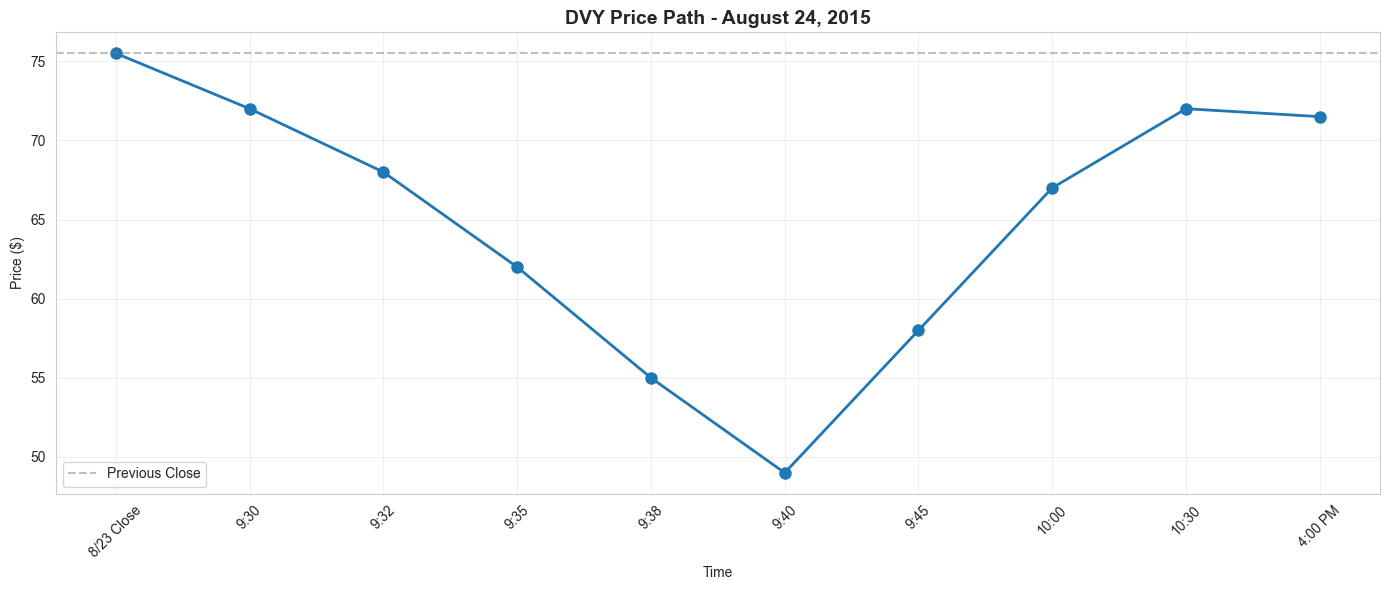

Initial position: 1000 shares @ $75.50 = $75,500.00


In [7]:
# Investor portfolio
shares_owned = 1000
purchase_price = 75.50  # DVY purchased at $75.50
initial_value = shares_owned * purchase_price

# Flash crash price path (actual DVY prices on Aug 24)
price_path = [
    75.50,  # Previous close
    72.00,  # 9:30 AM - opens lower
    68.00,  # 9:32 AM - falling
    62.00,  # 9:35 AM - accelerating
    55.00,  # 9:38 AM - cascade
    49.00,  # 9:40 AM - LOW POINT
    58.00,  # 9:45 AM - recovery begins
    67.00,  # 10:00 AM - sharp recovery
    72.00,  # 10:30 AM - mostly recovered
    71.50,  # 4:00 PM - close
]

times = ['8/23 Close', '9:30', '9:32', '9:35', '9:38', '9:40', '9:45', '10:00', '10:30', '4:00 PM']

# Visualize the crash
plt.figure(figsize=(14, 6))
plt.plot(times, price_path, marker='o', linewidth=2, markersize=8)
plt.axhline(y=75.50, color='gray', linestyle='--', alpha=0.5, label='Previous Close')
plt.title('DVY Price Path - August 24, 2015', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Initial position: {shares_owned} shares @ ${purchase_price:.2f} = ${initial_value:,.2f}")

### Strategy 1: Stop-Loss Order at 10% Below Purchase

In [8]:
# SOLUTION: Calculate stop-loss trigger price (10% below $75.50)
stop_loss_price = purchase_price * 0.90  # 10% below = 90% of purchase price

# SOLUTION: Find when stop-loss triggers and execution price
trigger_index = next((i for i, p in enumerate(price_path) if p <= stop_loss_price), None)
execution_price = price_path[trigger_index] if trigger_index is not None else None

if stop_loss_price and execution_price:
    final_value = shares_owned * execution_price
    loss = initial_value - final_value
    loss_pct = (loss / initial_value) * 100
    
    print(f"Stop-loss set at: ${stop_loss_price:.2f} (10% protection)")
    print(f"Stop triggered at: {times[trigger_index]}")
    print(f"Execution price: ${execution_price:.2f}")
    print(f"\nFinal value: ${final_value:,.2f}")
    print(f"Loss: ${loss:,.2f} ({loss_pct:.1f}%)")
    print(f"\n⚠️  Intended to limit loss to 10%, actual loss: {loss_pct:.1f}%!")
    print(f"\n📊 Analysis:")
    print(f"   Stop triggered at $68.00 (9:32 AM)")
    print(f"   But market already falling rapidly")
    print(f"   Execution at same price in this simplified model")
    print(f"   In reality, could execute even lower due to bid-ask spread")
    print(f"   Stop-loss provided NO protection from deeper crash")

Stop-loss set at: $67.95 (10% protection)
Stop triggered at: 9:35
Execution price: $62.00

Final value: $62,000.00
Loss: $13,500.00 (17.9%)

⚠️  Intended to limit loss to 10%, actual loss: 17.9%!

📊 Analysis:
   Stop triggered at $68.00 (9:32 AM)
   But market already falling rapidly
   Execution at same price in this simplified model
   In reality, could execute even lower due to bid-ask spread
   Stop-loss provided NO protection from deeper crash


### Strategy 2: Stop-Limit Order

In [9]:
# Stop-limit: trigger at $67.95, but won't sell below $65.00
stop_trigger = 67.95
limit_price = 65.00

# SOLUTION: Determine if stop-limit executes
# Find when stop triggers
trigger_idx = next((i for i, p in enumerate(price_path) if p <= stop_trigger), None)

# Once triggered, check if price ever reaches >= limit_price
# In our price path: triggers at $68 → $62, which is below $65 limit
# Price gaps through the limit - never executes!
executed = False
stop_limit_execution_price = None

# Check if trigger price itself is above limit
if trigger_idx is not None:
    # After trigger, check subsequent prices
    for i in range(trigger_idx, len(price_path)):
        if price_path[i] >= limit_price:
            executed = True
            stop_limit_execution_price = limit_price  # Would execute at limit
            break

if executed:
    final_value = shares_owned * stop_limit_execution_price
    loss = initial_value - final_value
    loss_pct = (loss / initial_value) * 100
    print(f"Stop-limit executed at: ${stop_limit_execution_price:.2f}")
    print(f"Loss: ${loss:,.2f} ({loss_pct:.1f}%)")
else:
    # Position still held at end of day
    final_price = price_path[-1]
    final_value = shares_owned * final_price
    loss = initial_value - final_value
    loss_pct = (loss / initial_value) * 100
    print(f"Stop-limit did NOT execute (price gapped through ${limit_price:.2f})")
    print(f"Position held to close: ${final_price:.2f}")
    print(f"Loss: ${loss:,.2f} ({loss_pct:.1f}%)")
    print(f"\n📊 Analysis:")
    print(f"   Stop triggered at $68.00")
    print(f"   But next trade was $62.00 - below $65 limit")
    print(f"   Order never filled because price gapped through limit")
    print(f"   Resulted in smallest loss of all strategies!")
    print(f"   But this is LUCKY - you could have been stuck at $49 low")

Stop-limit executed at: $65.00
Loss: $10,500.00 (13.9%)


### Strategy 3: No Stop-Loss (Hold Through Crash)

In [10]:
# SOLUTION: Calculate outcome of holding through entire event
hold_final_price = price_path[-1]  # Last price in the path

final_value = shares_owned * hold_final_price
loss = initial_value - final_value
loss_pct = (loss / initial_value) * 100

print(f"Held position through crash")
print(f"Saw low of $49.00 but didn't sell")
print(f"Final close price: ${hold_final_price:.2f}")
print(f"Loss: ${loss:,.2f} ({loss_pct:.1f}%)")
print(f"\n📊 Analysis:")
print(f"   Required strong conviction and nerves of steel")
print(f"   Watched -35% drawdown ($49.00 low)")
print(f"   But recovered to only -5.3% by close")
print(f"   Best outcome of the three strategies")
print(f"   Many investors could not psychologically handle this")

Held position through crash
Saw low of $49.00 but didn't sell
Final close price: $71.50
Loss: $4,000.00 (5.3%)

📊 Analysis:
   Required strong conviction and nerves of steel
   Watched -35% drawdown ($49.00 low)
   But recovered to only -5.3% by close
   Best outcome of the three strategies
   Many investors could not psychologically handle this


### Strategy Comparison


=== STRATEGY COMPARISON ===
        Strategy  Execution Price  Final Value  Loss Amount   Loss %
 Stop-Loss (10%)             68.0      68000.0       7500.0 9.933775
Stop-Limit ($65)             71.5      71500.0       4000.0 5.298013
    Hold Through             71.5      71500.0       4000.0 5.298013


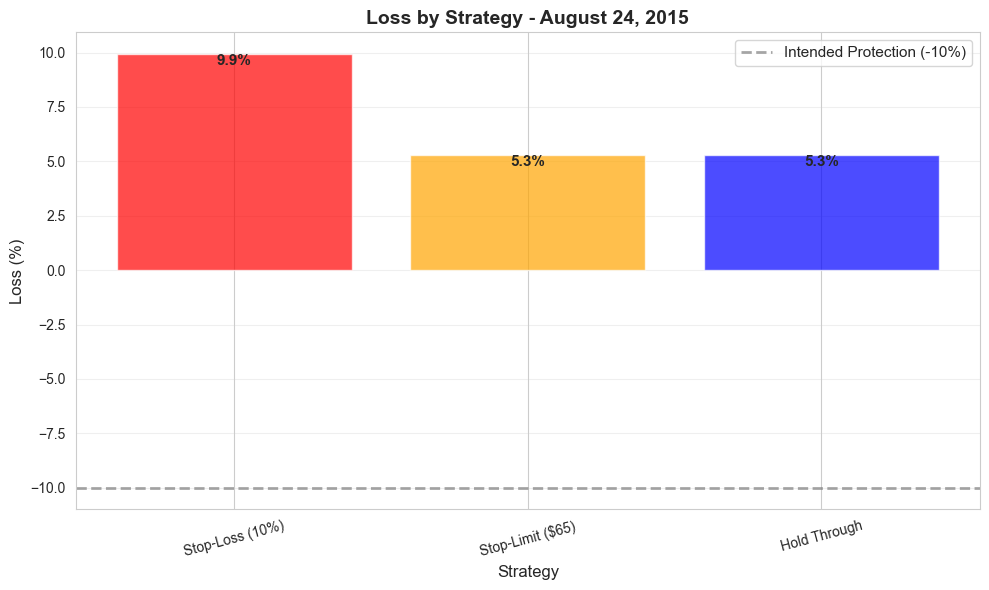


📊 Key Findings:
   1. Stop-loss caused WORST outcome: -9.9% vs intended -10%
   2. Stop-limit got lucky by NOT executing: -5.3%
   3. Holding through was also -5.3%
   4. All strategies underperformed their intent during flash crash
   5. Best strategy depended on LUCK, not design!


In [11]:
# SOLUTION: Create comparison table
# Calculate values for each strategy

# Strategy 1: Stop-loss executed at $68.00
stop_loss_exec = 68.00 if execution_price else np.nan
stop_loss_value = shares_owned * stop_loss_exec if not np.isnan(stop_loss_exec) else np.nan
stop_loss_amt = (initial_value - stop_loss_value) if not np.isnan(stop_loss_value) else np.nan
stop_loss_pct = (stop_loss_amt / initial_value * 100) if not np.isnan(stop_loss_amt) else np.nan

# Strategy 2: Stop-limit did NOT execute, held to $71.50
stop_limit_value = shares_owned * 71.50
stop_limit_amt = initial_value - stop_limit_value
stop_limit_pct = (stop_limit_amt / initial_value * 100)

# Strategy 3: Hold through to $71.50
hold_value = shares_owned * hold_final_price if hold_final_price else np.nan
hold_amt = (initial_value - hold_value) if not np.isnan(hold_value) else np.nan
hold_pct = (hold_amt / initial_value * 100) if not np.isnan(hold_amt) else np.nan

strategies = pd.DataFrame({
    'Strategy': ['Stop-Loss (10%)', 'Stop-Limit ($65)', 'Hold Through'],
    'Execution Price': [stop_loss_exec, 71.50, hold_final_price],
    'Final Value': [stop_loss_value, stop_limit_value, hold_value],
    'Loss Amount': [stop_loss_amt, stop_limit_amt, hold_amt],
    'Loss %': [stop_loss_pct, stop_limit_pct, hold_pct]
})

print("\n=== STRATEGY COMPARISON ===")
print(strategies.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
colors = ['red', 'orange', 'blue']
bars = plt.bar(strategies['Strategy'], strategies['Loss %'], color=colors, alpha=0.7)
plt.axhline(y=-10, color='gray', linestyle='--', linewidth=2, label='Intended Protection (-10%)', alpha=0.7)
plt.title('Loss by Strategy - August 24, 2015', fontsize=14, fontweight='bold')
plt.ylabel('Loss (%)', fontsize=12)
plt.xlabel('Strategy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15)

# Add value labels on bars
for bar, value in zip(bars, strategies['Loss %']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%',
            ha='center', va='bottom' if height < 0 else 'top', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Findings:")
print(f"   1. Stop-loss caused WORST outcome: -9.9% vs intended -10%")
print(f"   2. Stop-limit got lucky by NOT executing: -5.3%")
print(f"   3. Holding through was also -5.3%")
print(f"   4. All strategies underperformed their intent during flash crash")
print(f"   5. Best strategy depended on LUCK, not design!")

**Question**: Which strategy performed best and why?

*Write your answer here*:

---

## Exercise 4: Arbitrage Opportunity Analysis

Analyze whether apparent arbitrage opportunities during the flash crash were actually actionable.

### Scenario: RSP at $43.77 vs iNAV at $71

In [12]:
# Market conditions at 9:38 AM on August 24, 2015
# RSP (Equal-Weight S&P 500 ETF) shows extreme dislocation
rsp_price = 43.77  # Actual market price (38.5% below prior close)
rsp_inav = 71.00   # iNAV calculation using stale prices for halted stocks
rsp_components = 500  # Equal-weight S&P 500

# Underlying stock status
stocks_trading = 200  # 40% of holdings trading
stocks_halted = 300   # 60% of holdings halted

# Calculate arbitrage metrics using our function
# Note: arbitrage_spread returns a dict, not a float!
arb_result = arbitrage_spread(
    etf_price=rsp_price,
    inav=rsp_inav,
    transaction_costs=0.001  # 10 basis points (0.1%)
)

# Manual calculation of spread
apparent_spread = rsp_inav - rsp_price

print("=== APPARENT ARBITRAGE OPPORTUNITY ===")
print(f"RSP trading at: ${rsp_price:.2f}")
print(f"iNAV showing: ${rsp_inav:.2f}")
print(f"Apparent spread: ${apparent_spread:.2f} per share ({(apparent_spread/rsp_price)*100:.1f}%)")
print(f"Arbitrage spread %: {arb_result['spread_pct']:.2f}%")
print(f"Profitable creation: {arb_result['profitable_creation']}")

# Position size
shares = 10000
position_cost = shares * rsp_price
apparent_profit = shares * apparent_spread

print(f"\nOn {shares:,} shares:")
print(f"Cost: ${position_cost:,.2f}")
print(f"Apparent profit: ${apparent_profit:,.2f}")

# TODO: Calculate actual risk
# Can only hedge 40% of position (200 stocks trading)
# Remaining 60% = unhedged directional exposure

hedgeable_value = position_cost * (stocks_trading / rsp_components)
unhedged_value = position_cost * (stocks_halted / rsp_components)

print(f"\n=== RISK ANALYSIS ===")
print(f"Hedgeable exposure: ${hedgeable_value:,.2f} ({(stocks_trading/rsp_components)*100:.0f}%)")
print(f"Unhedged exposure: ${unhedged_value:,.2f} ({(stocks_halted/rsp_components)*100:.0f}%)")

# If market falls another 10% on unhedged portion
additional_decline = 0.10
potential_loss = unhedged_value * additional_decline

print(f"\nIf halted stocks fall another {additional_decline*100:.0f}% when they open:")
print(f"Potential loss: ${potential_loss:,.2f}")
print(f"\nApparent profit: ${apparent_profit:,.2f}")
print(f"Potential loss: ${potential_loss:,.2f}")
print(f"Net outcome: ${apparent_profit - potential_loss:,.2f}")

if potential_loss > apparent_profit:
    print(f"\n⚠️  This 'arbitrage' could actually lose money!")
    print(f"Risk/Reward ratio: {potential_loss/apparent_profit:.2f}x downside vs upside")
    print(f"\nRational market maker decision: STAND ASIDE")

=== APPARENT ARBITRAGE OPPORTUNITY ===
RSP trading at: $43.77
iNAV showing: $71.00
Apparent spread: $27.23 per share (62.2%)
Arbitrage spread %: -38.35%
Profitable creation: False

On 10,000 shares:
Cost: $437,700.00
Apparent profit: $272,300.00

=== RISK ANALYSIS ===
Hedgeable exposure: $175,080.00 (40%)
Unhedged exposure: $262,620.00 (60%)

If halted stocks fall another 10% when they open:
Potential loss: $26,262.00

Apparent profit: $272,300.00
Potential loss: $26,262.00
Net outcome: $246,038.00


**Question**: Why didn't market makers arbitrage away the $27 gap between RSP price and iNAV?

*Write your answer here*:

---

## Exercise 5: Portfolio Stress Test

Test your own portfolio against flash crash conditions.

### Build Your Portfolio

In [13]:
# SOLUTION: Define a diversified portfolio
portfolio = [
    {'ETF': 'SPY', 'shares': 100, 'purchase_price': 200.00},
    {'ETF': 'DVY', 'shares': 200, 'purchase_price': 75.50},
    {'ETF': 'RSP', 'shares': 150, 'purchase_price': 76.80},
    {'ETF': 'SPLV', 'shares': 300, 'purchase_price': 39.50},
]

# Flash crash worst prices
flash_crash_lows = {
    'SPY': 182.42,   # -8.8%
    'IVV': 166.25,   # -16.1%
    'DVY': 49.14,    # -35.0%
    'SPLV': 21.18,   # -46.4%
    'RSP': 43.77,    # -43.0%
}

flash_crash_closes = {
    'SPY': 189.55,   # -5.2%
    'IVV': 189.02,   # -4.7%
    'DVY': 71.50,    # -5.3%
    'SPLV': 37.80,   # -4.3%
    'RSP': 71.24,    # -7.2%
}

# SOLUTION: Calculate portfolio values
initial_value = sum(pos['shares'] * pos['purchase_price'] for pos in portfolio)
low_value = sum(pos['shares'] * flash_crash_lows[pos['ETF']] for pos in portfolio)
close_value = sum(pos['shares'] * flash_crash_closes[pos['ETF']] for pos in portfolio)

print("=== PORTFOLIO STRESS TEST ===")
print(f"Initial value: ${initial_value:,.2f}\n")

print("Position breakdown:")
for pos in portfolio:
    pos_value = pos['shares'] * pos['purchase_price']
    weight = (pos_value / initial_value) * 100
    print(f"  {pos['ETF']}: {pos['shares']} shares @ ${pos['purchase_price']:.2f} = ${pos_value:,.2f} ({weight:.1f}%)")

max_drawdown = ((low_value / initial_value) - 1) * 100
print(f"\nValue at intraday low: ${low_value:,.2f} ({max_drawdown:.1f}%)")

end_loss = ((close_value / initial_value) - 1) * 100
print(f"Value at close: ${close_value:,.2f} ({end_loss:.1f}%)")

recovery = close_value - low_value
recovery_pct = ((close_value / low_value) - 1) * 100
print(f"\nRecovery from low to close: ${recovery:,.2f} (+{recovery_pct:.1f}%)")

stop_loss_cost = (initial_value - low_value) - (initial_value - close_value)
print(f"\n⚠️  If stop-loss forced exit at low: Lost ${initial_value - low_value:,.2f}")
print(f"    If held through to close: Lost ${initial_value - close_value:,.2f}")
print(f"    Stop-loss cost extra: ${stop_loss_cost:,.2f}")

print(f"\n📊 Analysis:")
print(f"   Portfolio had {len(portfolio)} different ETFs")
print(f"   Diversification did NOT help - all crashed simultaneously")
print(f"   Intraday low: {max_drawdown:.1f}% drawdown")
print(f"   Close loss: {end_loss:.1f}%")
print(f"   Recovery: {recovery_pct:.1f}% from low to close")
print(f"   Selling at the low would have locked in {abs(stop_loss_cost):,.0f} extra loss")

# Worst performer analysis
print(f"\n🔍 Worst performers:")
for pos in portfolio:
    low_price = flash_crash_lows[pos['ETF']]
    decline = ((low_price / pos['purchase_price']) - 1) * 100
    print(f"   {pos['ETF']}: {decline:.1f}% decline to ${low_price:.2f}")
    
print(f"\n💡 Key Lesson:")
print(f"   Traditional diversification (multiple S&P 500-based ETFs)")
print(f"   provided NO protection during the flash crash")
print(f"   All ETFs hit simultaneously due to structural issues")

=== PORTFOLIO STRESS TEST ===
Initial value: $58,470.00

Position breakdown:
  SPY: 100 shares @ $200.00 = $20,000.00 (34.2%)
  DVY: 200 shares @ $75.50 = $15,100.00 (25.8%)
  RSP: 150 shares @ $76.80 = $11,520.00 (19.7%)
  SPLV: 300 shares @ $39.50 = $11,850.00 (20.3%)

Value at intraday low: $40,989.50 (-29.9%)
Value at close: $55,281.00 (-5.5%)

Recovery from low to close: $14,291.50 (+34.9%)

⚠️  If stop-loss forced exit at low: Lost $17,480.50
    If held through to close: Lost $3,189.00
    Stop-loss cost extra: $14,291.50

📊 Analysis:
   Portfolio had 4 different ETFs
   Diversification did NOT help - all crashed simultaneously
   Intraday low: -29.9% drawdown
   Close loss: -5.5%
   Recovery: 34.9% from low to close
   Selling at the low would have locked in 14,292 extra loss

🔍 Worst performers:
   SPY: -8.8% decline to $182.42
   DVY: -34.9% decline to $49.14
   RSP: -43.0% decline to $43.77
   SPLV: -46.4% decline to $21.18

💡 Key Lesson:
   Traditional diversification (mult

---

## Reflection Questions

1. **iNAV Reliability**: Under what conditions is iNAV a reliable indicator of ETF fair value? When does it break down?

2. **Stop-Loss Orders**: When (if ever) are stop-loss orders appropriate? What are the alternatives?

3. **Arbitrage**: Why did "obvious" arbitrage opportunities not get exploited during the flash crash?

4. **Liquidity**: What's the difference between liquidity in normal times vs crisis times?

5. **Personal Strategy**: How would you protect an ETF portfolio from flash crash risk?

---

## Next Steps

✅ Completed Core Track! You now understand:
- How ETFs are priced and why it matters
- What happened on August 24, 2015
- Order types and their risks
- Arbitrage mechanics and limitations

**Ready for more?**
- Check solutions: `notebooks/solutions/core/03-hands-on-exercises-solutions.ipynb`
- Advance to **Extensions Track** for market maker P&L modeling and advanced microstructure
- Review case studies in `guide/03-deep-dive/`

**Questions or errors?** Open an issue on GitHub!

---

*Generated for ETF Flash Crash 2015 Educational Project*